### **Baseline Hypothesis:**
#### **Building a Toxicity Classifier and substituting toxic words with synonyms from NLTK Lesk**
For our classifier, we will use logistic regression model. We will train this model to distinguish between toxic and non-toxic words. 

To accomplish this, we will use the following dataset for our baseline classifier:

In [17]:
import pandas as pd
import sys
sys.path.insert(0, '..')
data = pd.read_csv('../data/interim/words.csv', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24645 entries, 0 to 24644
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    24640 non-null  object
 1   target  24645 non-null  object
dtypes: object(2)
memory usage: 577.6+ KB


In [18]:
print(f'Number of words in dataset: {len(data)}')
print(f'Unique words in dataset: {len(data["word"].unique())}')
print(f'Nulls: {data["word"].isna().sum()}')

Number of words in dataset: 24645
Unique words in dataset: 12670
Nulls: 5


Drop rows without words and duplicate rows

In [19]:
data = data.dropna(subset=['word'])
data = data.drop_duplicates()

Same Words can be both negative and positive meanings based on context, which is why we categorize them as "Negative" to prevent False Positive identifications. This approach can enhance precision scores but may result in a decrease in recall, as it could lead to more instances of False Negatives. For our specific task, this is not particularly crucial, as we have the option to substitute positive words with alternative positive terms.

![Alt text](https://www.researchgate.net/publication/336402347/figure/fig3/AS:812472659349505@1570719985505/Calculation-of-Precision-Recall-and-Accuracy-in-the-confusion-matrix.ppm "a title")


In [20]:
data.loc[data['word'].duplicated(keep=False), 'target'] = 'Negative'
data = data.drop_duplicates()

In [21]:
print(f'Number of words in dataset: {len(data)}')
print(f'Unique words in dataset: {len(data["word"].unique())}')
print(f'Nulls: {data["word"].isna().sum()}')

Number of words in dataset: 12669
Unique words in dataset: 12669
Nulls: 0


Let's see the distribution of target value

<BarContainer object of 2 artists>

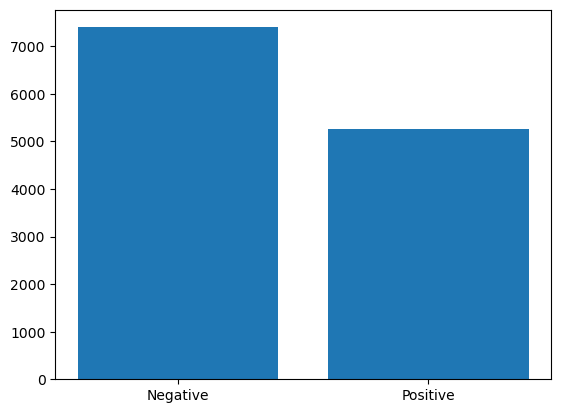

In [22]:
import matplotlib.pyplot as plt
target_counts = data['target'].value_counts()
target_counts.sort_index()
plt.bar(target_counts.index, target_counts.values)

In [23]:
data['target'] = data['target'].replace({'Positive': 0, 'Negative': 1})
X_train, y_train = data['word'], data['target']

#### **Simple preprocessing**:
1. Convert all characters to lowercase.
2. Remove punctuation marks
3. Tokenize the text

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
import string
from nltk.tokenize import word_tokenize

def Preprocessor(text):
    
    if isinstance(text, list):
        text = pd.Series(text)

    if isinstance(text, pd.core.series.Series):
        return text.str.lower().str.strip()
    elif isinstance(text, str):
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = text.lower()
        tokenized = word_tokenize(text)
        return tokenized


classificator = Pipeline([
    ('preprocessor', FunctionTransformer(func=Preprocessor)),
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

classificator.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 FunctionTransformer(func=<function Preprocessor at 0x00000154BA5EC700>)),
                ('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

#### **Lesk Algorithm**

Performs the classic Lesk algorithm for Word Sense Disambiguation (WSD) using the definitions of the ambiguous word.

Given an ambiguous word and the context in which the word occurs, Lesk returns a Synset, or a set of synonymous words, that exhibits the most substantial overlap with the words found in the context sentence.


In [25]:
from nltk.wsd import lesk
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')


def paraphraser(sentence):
    stop_words = set(stopwords.words('english'))

    def get_synonym_by_context(word, context_sentence):

        sense = lesk(context_sentence, word)
        synonyms = []
        if sense:
            for lemma in sense.lemmas():
                synonyms.append(lemma.name().replace('_', ' '))

        # Remove duplicates and display the closest synonym
        synonyms = list(set(synonyms))
        if len(synonyms) == 0:
            synonyms.append(word)
        #rearrange synonyms by they toxicity
        synonyms = sorted([(synonym, classificator.predict_proba(synonym)[0, 1]) for synonym in synonyms], key= lambda x: x[1])
        return synonyms[0][0]

    tokenized = Preprocessor(sentence)
    predictions = classificator.predict(tokenized)
    mask = np.array([0 if word in stop_words else 1 for word in tokenized])
    predictions = predictions * mask
    assert len(predictions) == len(tokenized)
    paraphrased = [get_synonym_by_context(word, sentence) if predictions[i] == 1 else word for i, word in enumerate(tokenized)]
    return ' '.join(paraphrased)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hir0\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hir0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
detox_data = pd.read_csv('../data/interim/test_filtered.csv')

In [27]:
X, y_true = detox_data['reference'].values, detox_data['translation'].values

print(X[1])
print(f'Pred: {paraphraser(X[1])}\nTrue: {y_true[1]}')

Oh, Grace, don't be ridiculous.
Pred: OH grace dont be silly
True: grace, don't be crazy!


In [ ]:
predictions_baseline = pd.DataFrame({'Predictions': [paraphraser(sentence) for sentence in X]})
predictions_baseline.to_csv('../data/interim/baseline_predictions.csv')

In [29]:
predictions_baseline = pd.read_csv('../data/interim/baseline_predictions.csv', index_col=0)
predictions_baseline = list(predictions_baseline['Predictions'].values)
predictions_baseline[:5]

['hot doll are starfuckers in coeur dalene',
 'Buckeye State grace dont be pathetic',
 'ii love yo sister',
 "next time you make up one's mind to take a bath private permit me know or poorly kick your ass",
 'i in the end catch you you marked-up']

In [30]:
from src.metric.metric import calculate_metric
calculate_metric(y_true, predictions_baseline)

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 518/518 [00:21<00:00, 24.53it/s]


Calculating BLEU similarity


c:\Users\hir0\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\hir0\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\hir0\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.

Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 518/518 [00:03<00:00, 131.47it/s]


Calculating CoLA acceptability stats


100%|██████████| 518/518 [01:01<00:00,  8.41it/s]


| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.5798|0.5306|0.6789|0.2075|0.3868|



{'ACC': 0.5797994442430833,
 'SIM': 0.530569537372181,
 'FL': 0.678929563851637,
 'J': 0.2074788008575805,
 'BLUE': 0.3868392437524953}